In [17]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# data
import pandas as pd
import numpy as np
from datetime import datetime

# trading & statistics
import backtrader as bt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
# from statsmodels.stats.diagnostic import acorr_ljungbox

# visualization
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
import seaborn as sns
# import cufflinks as cf
# cf.go_offline()
# init_notebook_mode()

In [4]:
df = pd.read_csv('../data/binance_btc_df.csv')
btc_df = df[df['symbol']=='BTCUSDT']
df['date'] = pd.to_datetime(df['open_time'])
df.drop(columns=['open_time'],inplace=True)
df.set_index('date', inplace=True)
df = df.iloc[:,1:5]
print(df.shape)
df.head()

(261637, 4)


,open,high,low,close
date,,,,
2020-01-01 08:00:00,7195.24,7196.25,7178.64,7179.78
2020-01-01 08:05:00,7179.76,7191.77,7178.20,7191.07
2020-01-01 08:10:00,7193.15,7193.53,7180.24,7180.97
2020-01-01 08:15:00,7180.97,7186.40,7177.35,7178.29
2020-01-01 08:20:00,7177.71,7182.46,7175.47,7176.96


In [5]:
# resampling
week_df = df[['close']].resample('W').last()
day_df = df[['close']].resample('D').last()

## Time Series

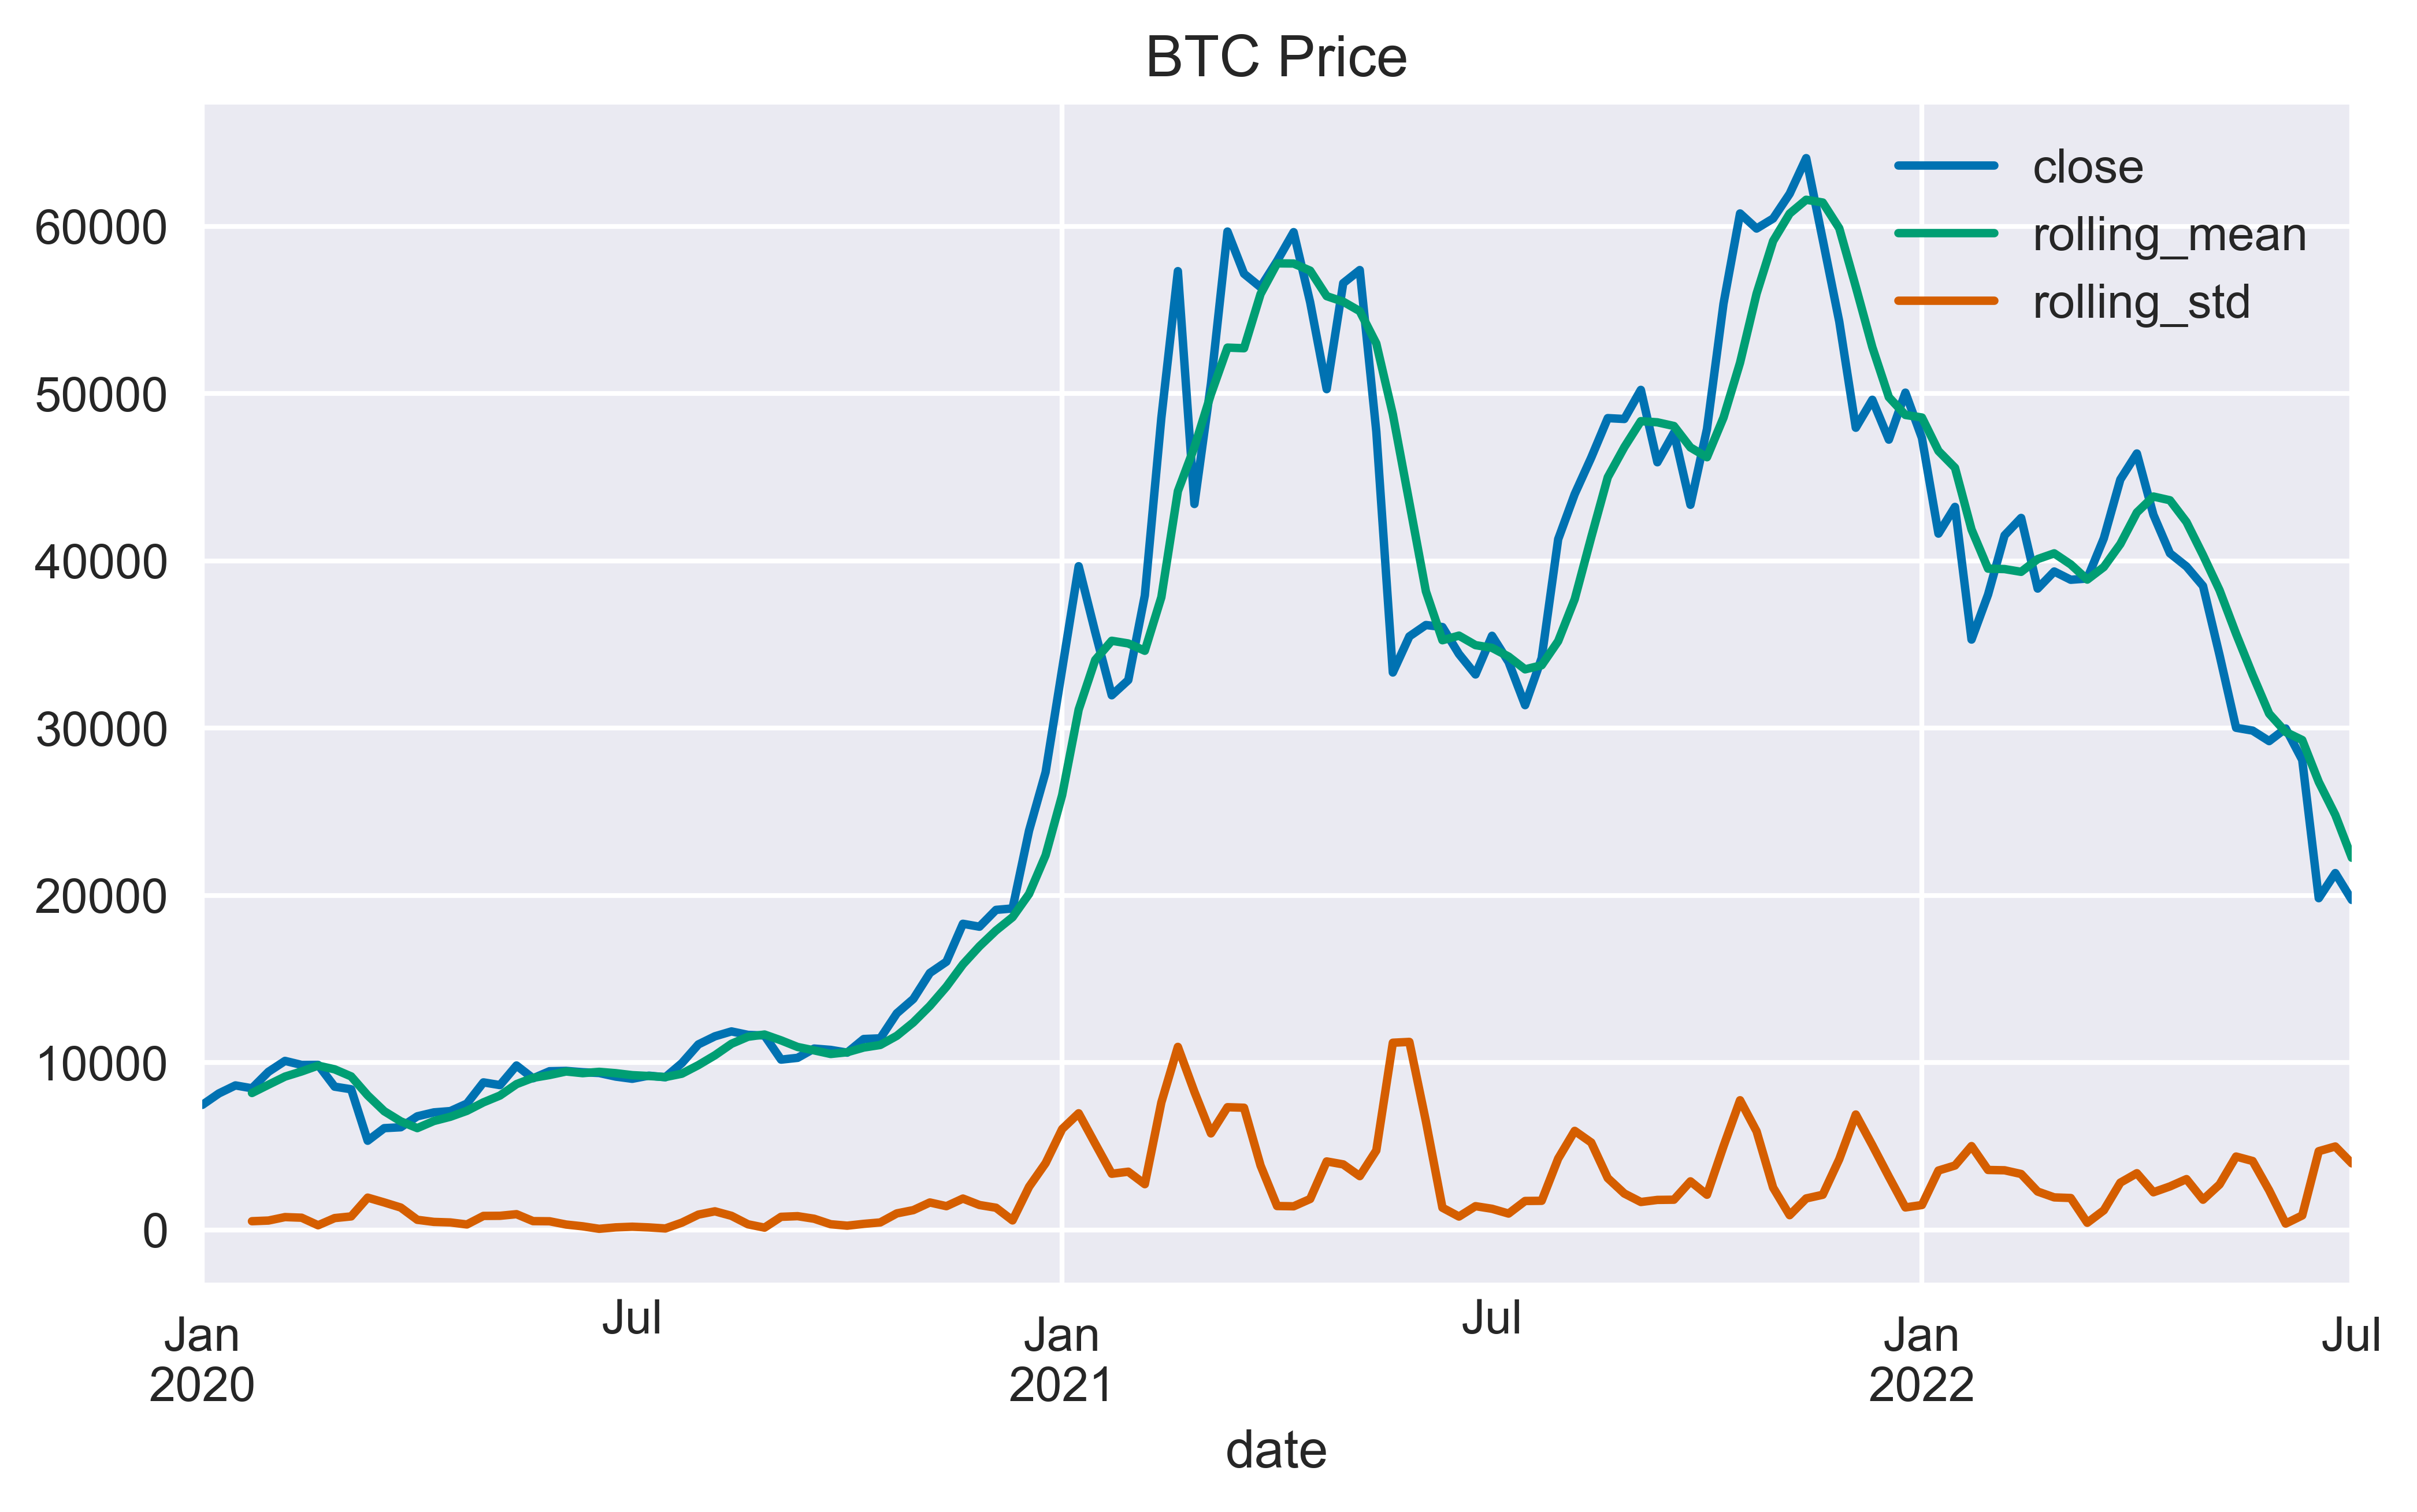

In [23]:
# weekly frequency
window = 4
week_df['rolling_mean'] = week_df.close.rolling(window=window).mean()
week_df['rolling_std'] = week_df.close.rolling(window=window).std()
week_df.plot(title='BTC Price')
plt.show()

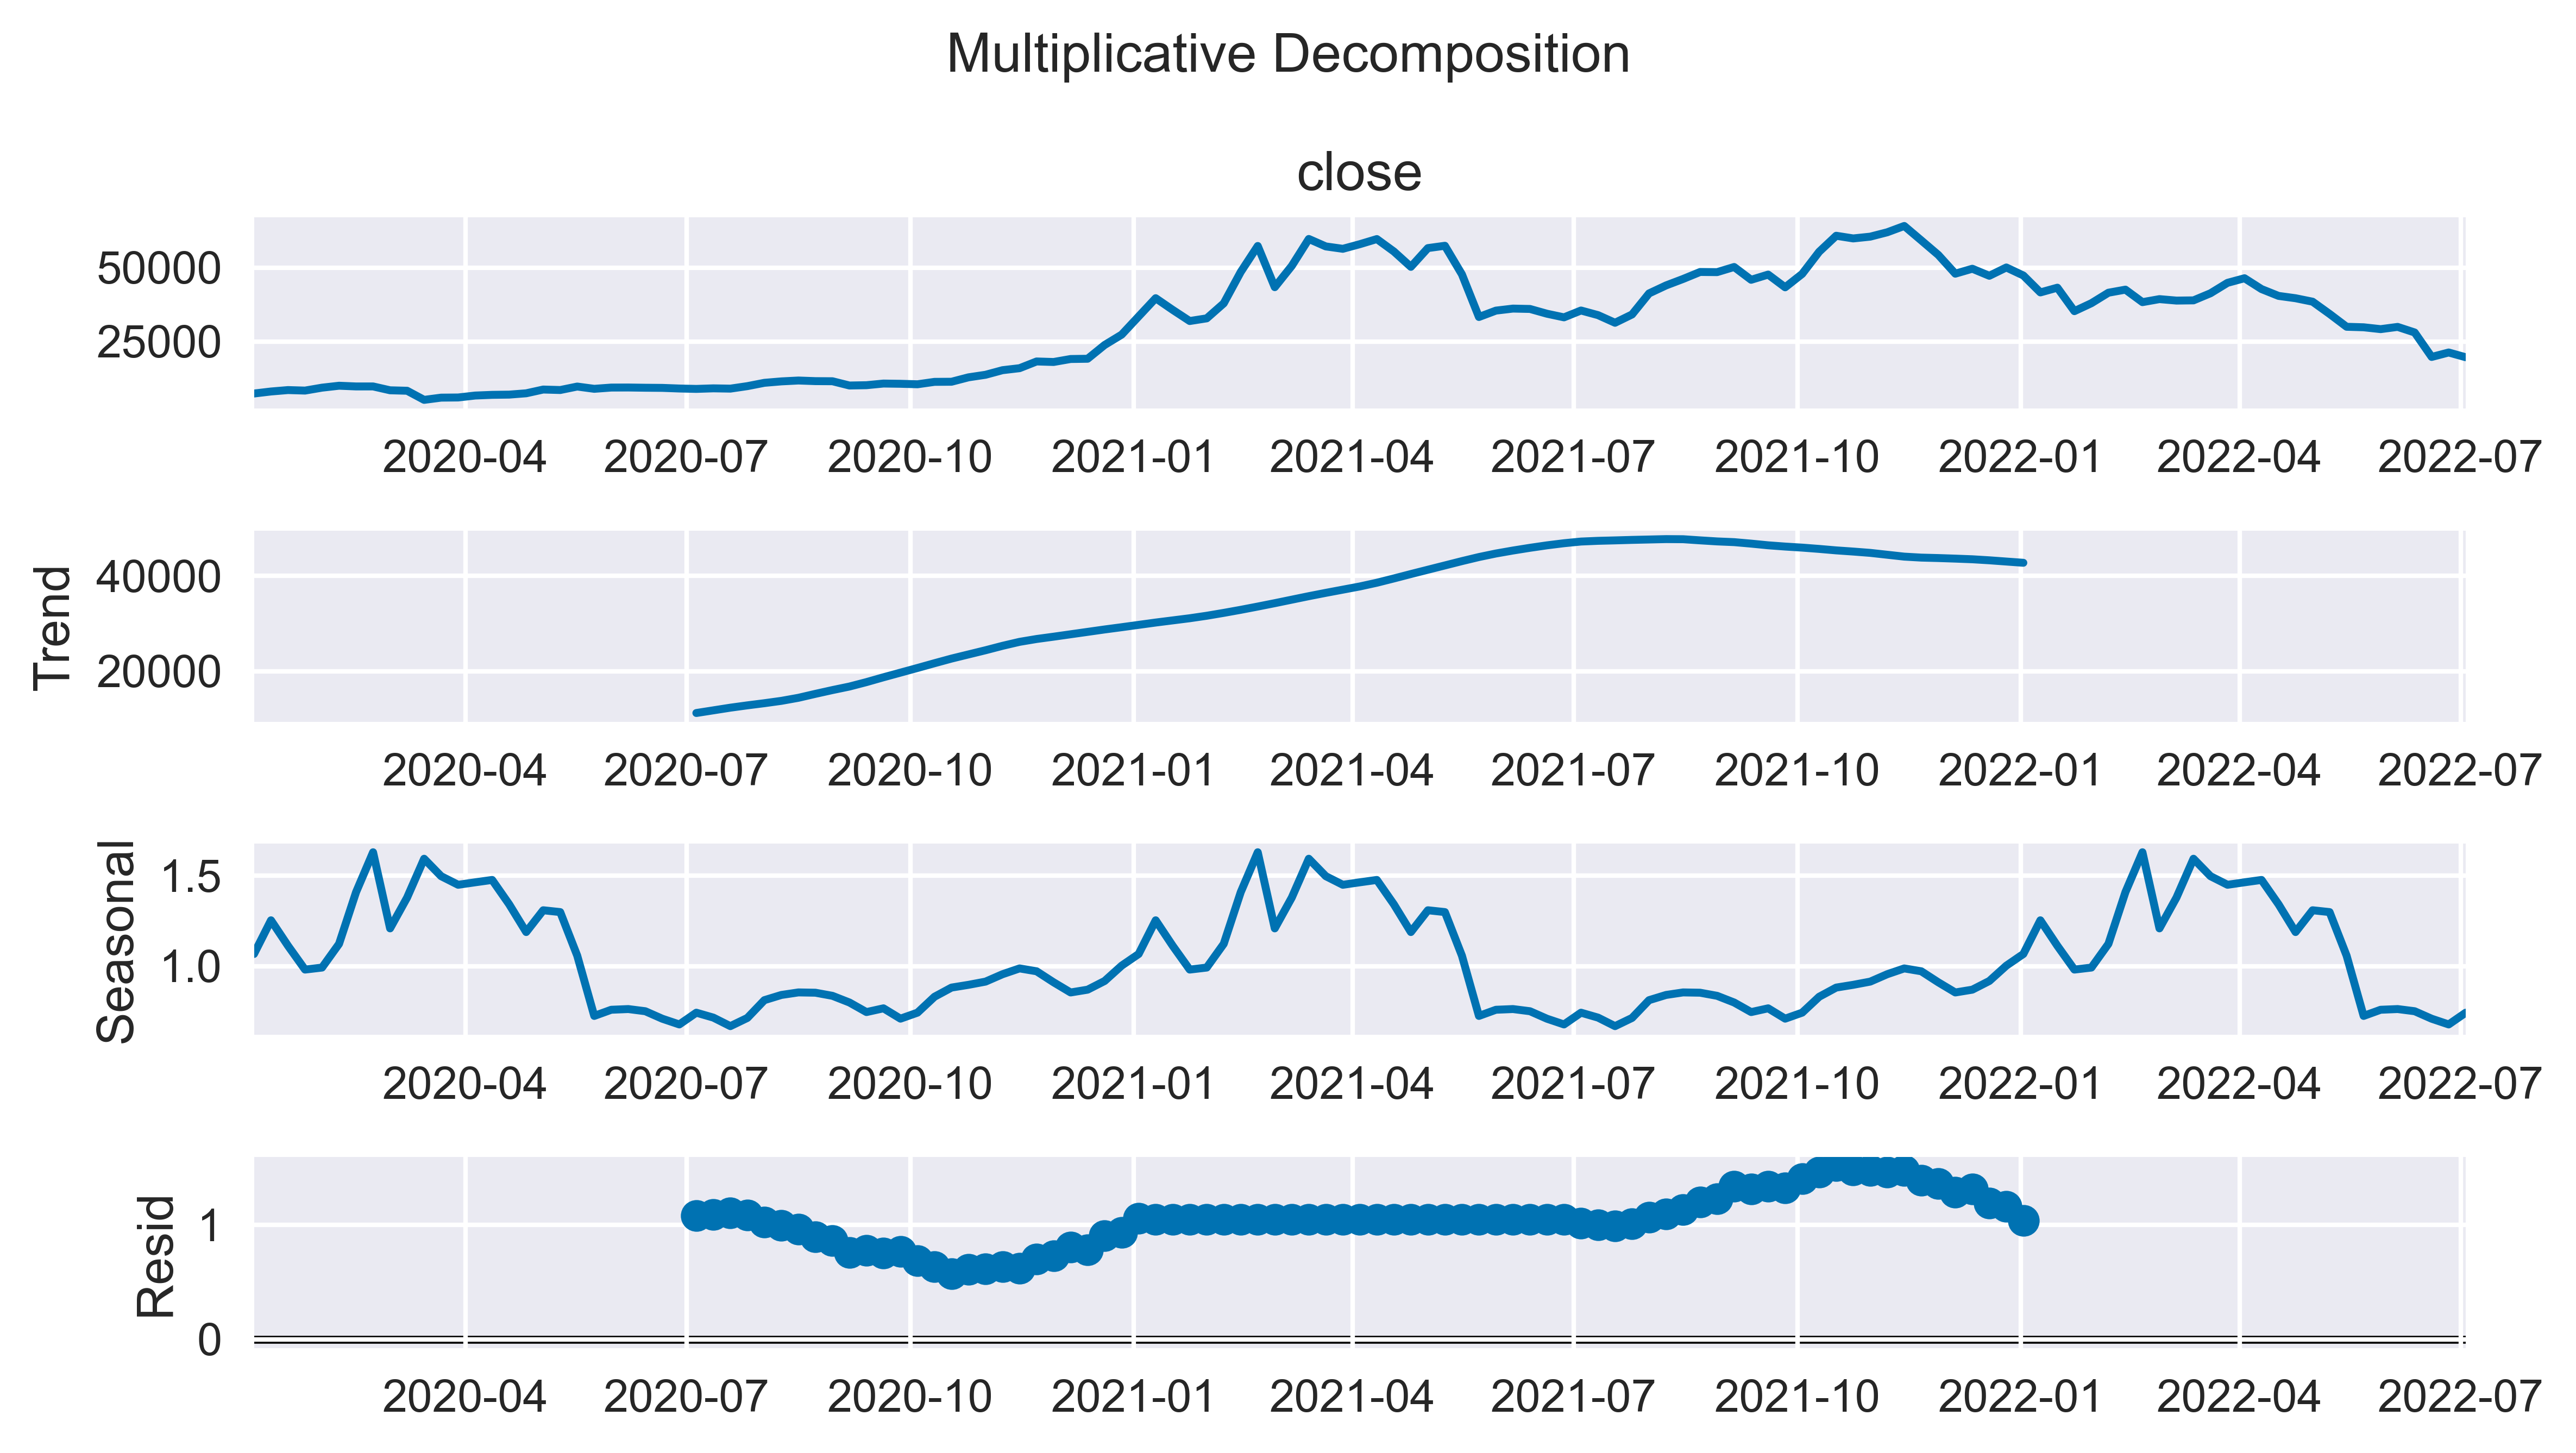

In [26]:
#Seasonal decomposition using the multiplicative model 
decomposition_results = seasonal_decompose(week_df.close, model='multiplicative')
decomposition_results.plot().suptitle('Multiplicative Decomposition')
plt.tight_layout()
plt.show()

### Testing for Stationarity

- Null Hypothesis: time series is not stationary
- Alternate Hypothesis: time series is stationary

In [28]:
# ADF / Augmented Dickey-Fuller test
def adf_test(x):
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    return results
adf_test(day_df.close)

Test Statistic             -1.430937
p-value                     0.567358
# of Lags Used              7.000000
# of Observations Used    905.000000
Critical Value (1%)        -3.437596
Critical Value (5%)        -2.864739
Critical Value (10%)       -2.568473
dtype: float64

In [31]:
# KPSS / Kwiatkowski-Phillips-Schmidt-Shin test
def kpss_test(x, h0_type='c'):
#     'c': The data is stationary around a constant(default)
#     'ct': The data is stationary around a trend
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    return results
kpss_test(day_df.close)

Test Statistic            3.110527
p-value                   0.010000
# of Lags                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

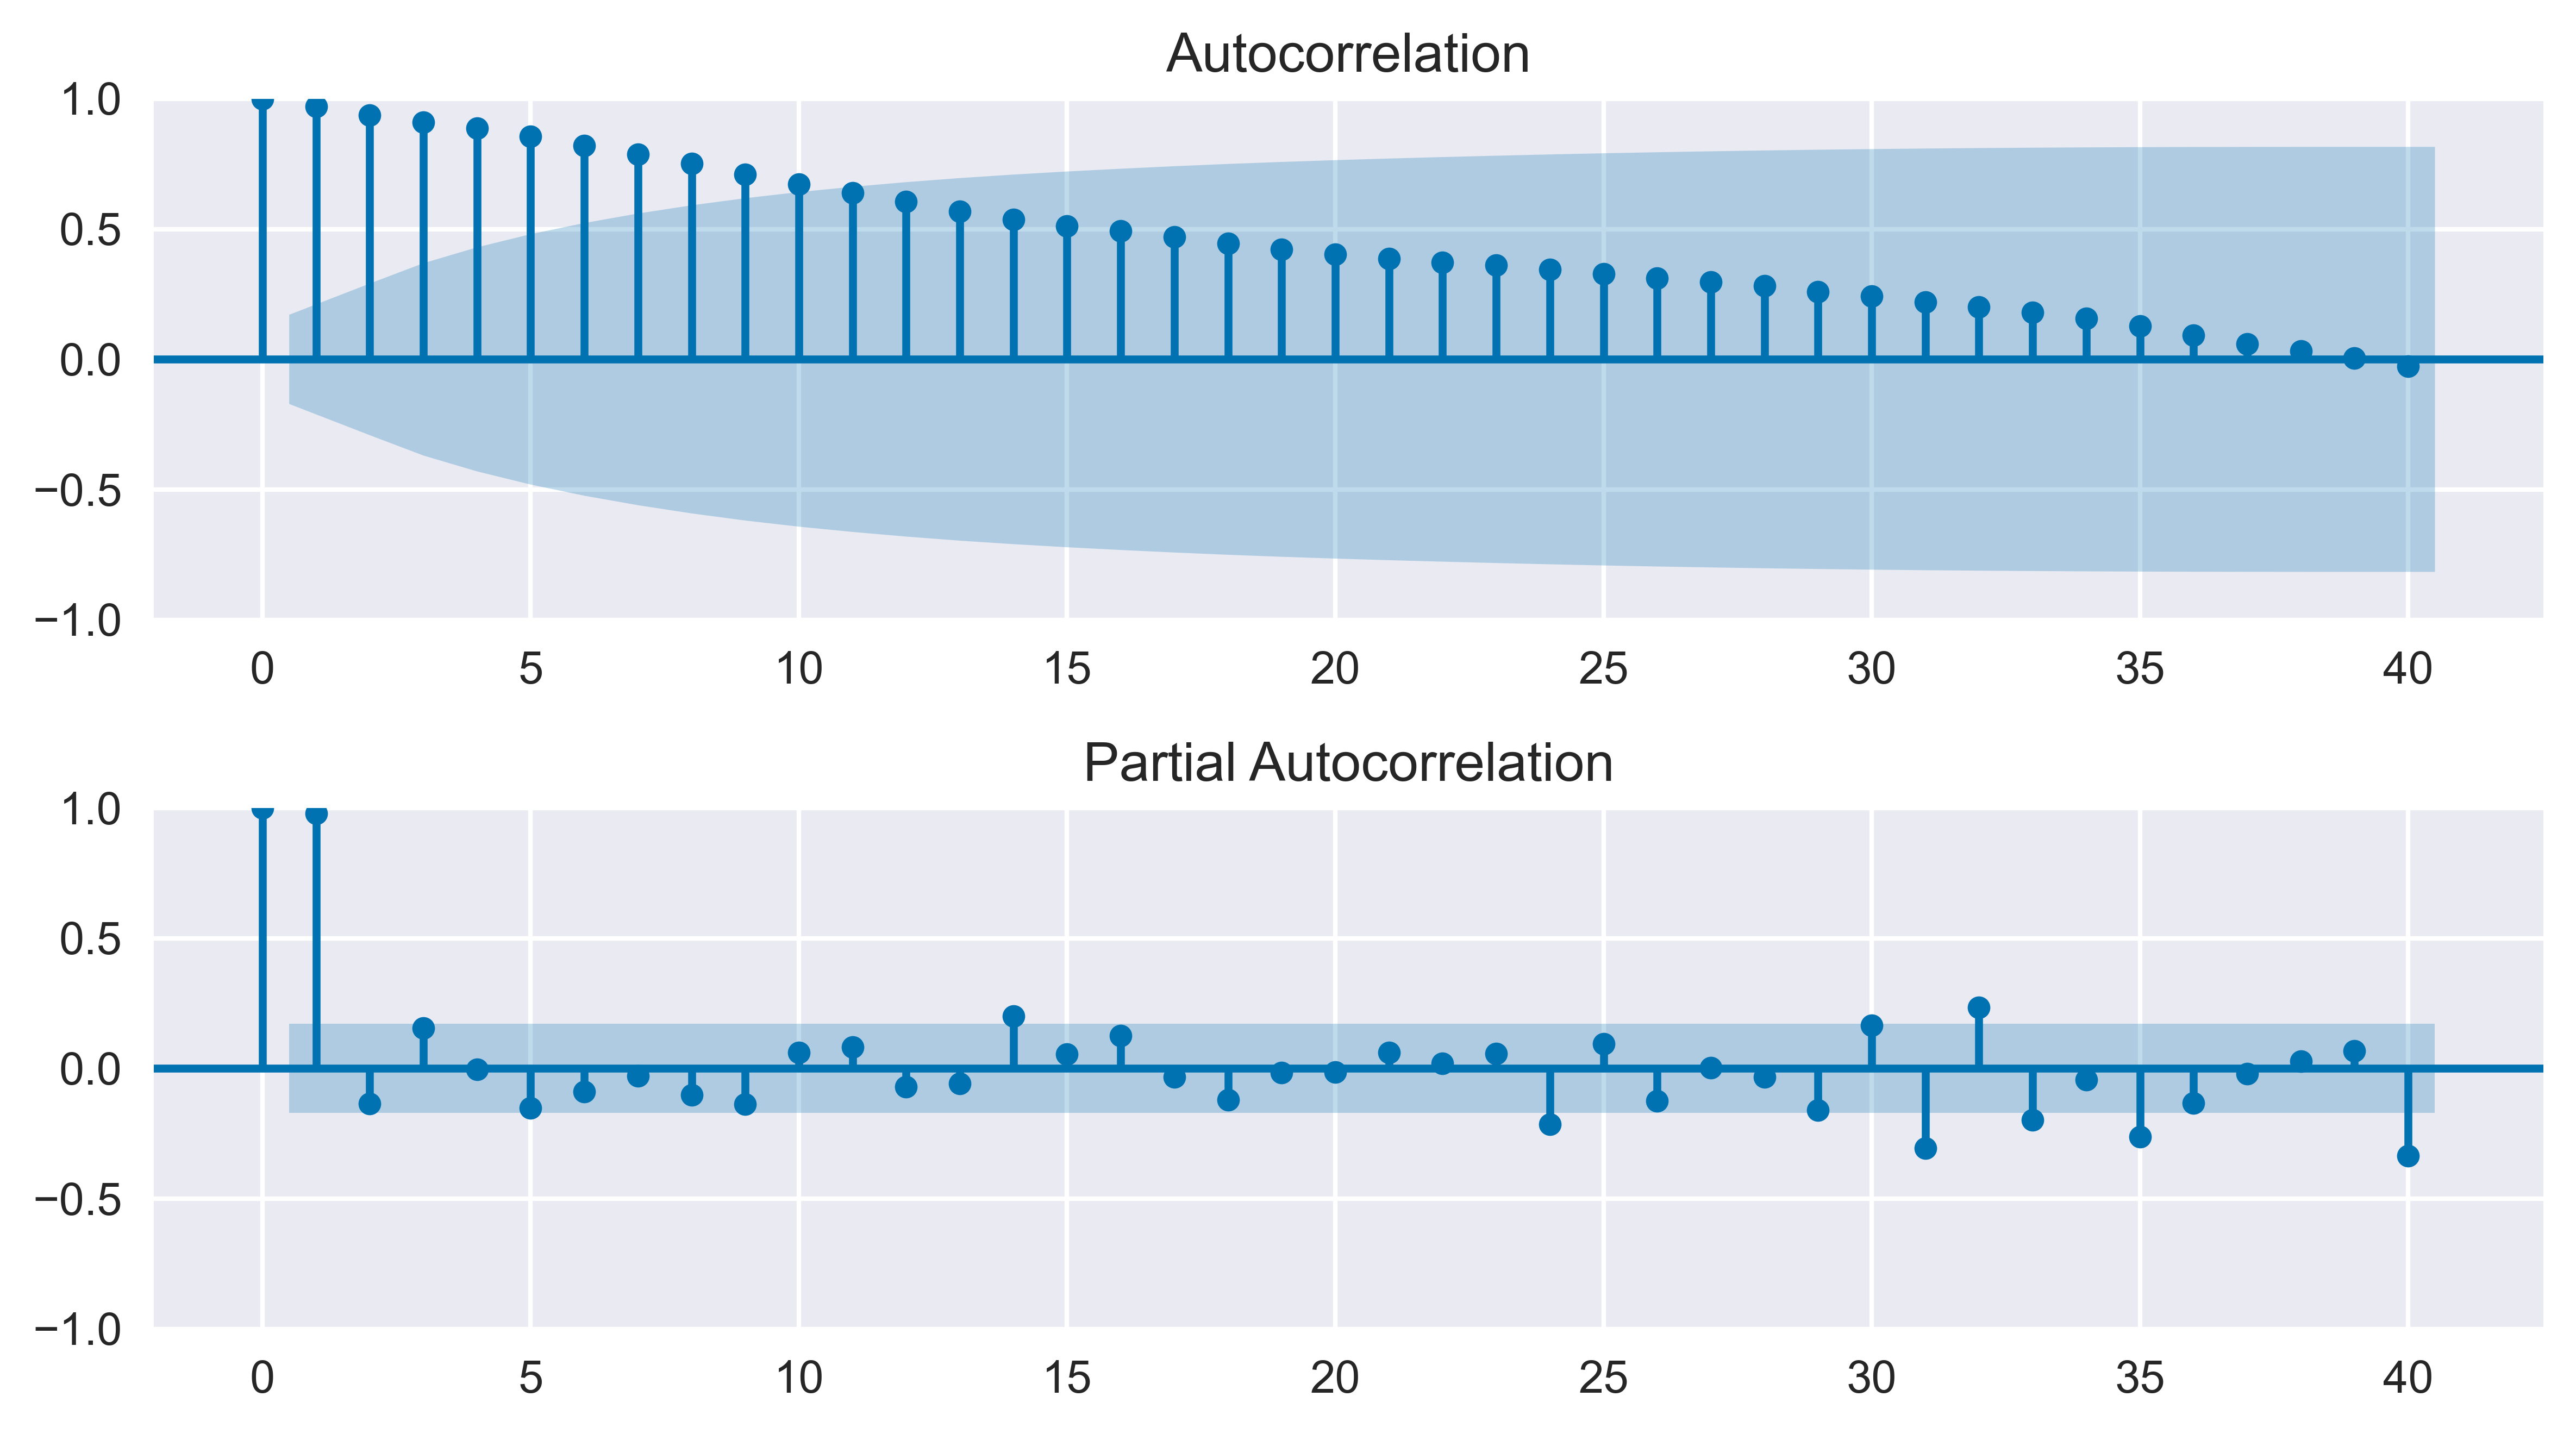

In [63]:
# ACF/ PACF plot
def acf_pacf(x,lags=40,sig_lvl=0.05):
    fig, ax = plt.subplots(2, 1)
    plot_acf(week_df.close, ax=ax[0], lags=lags, alpha=sig_lvl)
    plot_pacf(week_df.close, ax=ax[1], lags=lags, alpha=sig_lvl)
    plt.tight_layout() 
    plt.show()
acf_pacf(day_df.close)

In [64]:
def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)
    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))
    acf_pacf(x)

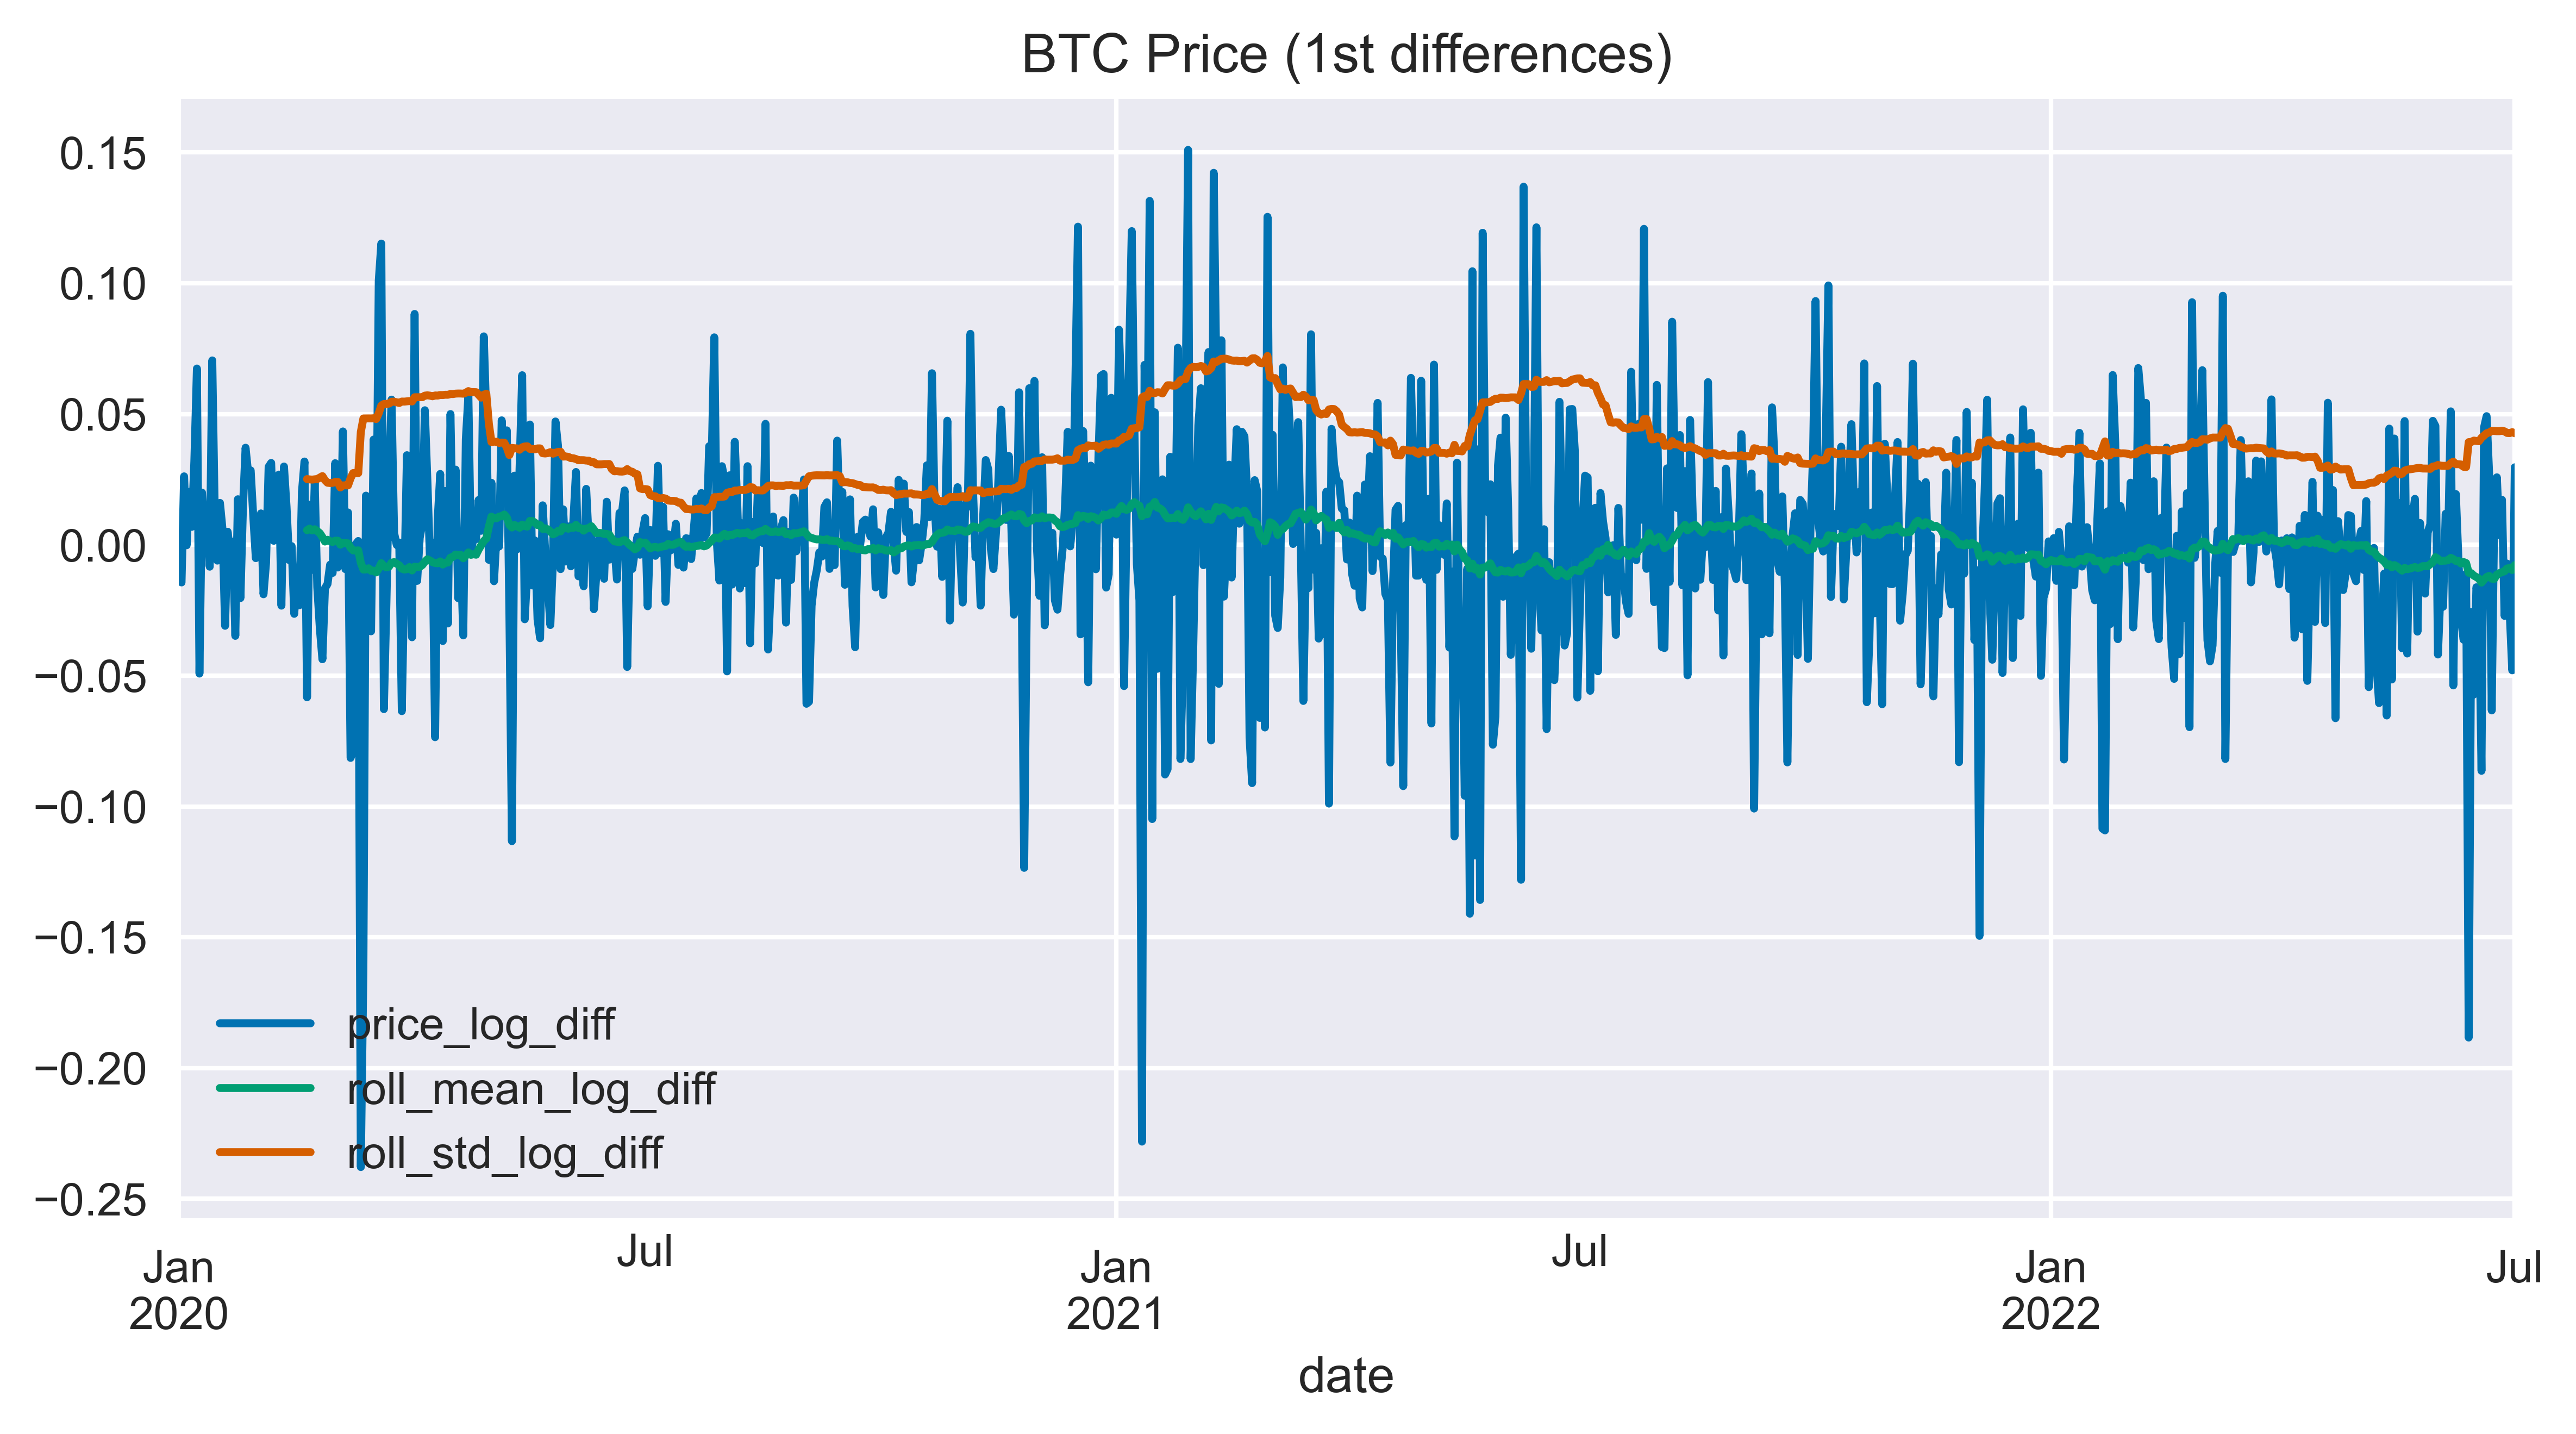

In [8]:
# differencing
window = 50
day_df['price_log'] = np.log(day_df.close)
day_df['price_log_diff'] = day_df.price_log.diff(1)
day_df['roll_mean_log_diff'] = day_df.price_log_diff.rolling(window).mean()
day_df['roll_std_log_diff'] = day_df.price_log_diff.rolling(window).std()
selected_columns = ['price_log_diff', 'roll_mean_log_diff', 'roll_std_log_diff']
day_df[selected_columns].plot(title='BTC Price (1st differences)')
plt.tight_layout()
plt.show()

ADF test statistic: -10.68 (p-val: 0.00)
KPSS test statistic: 0.55 (p-val: 0.03)


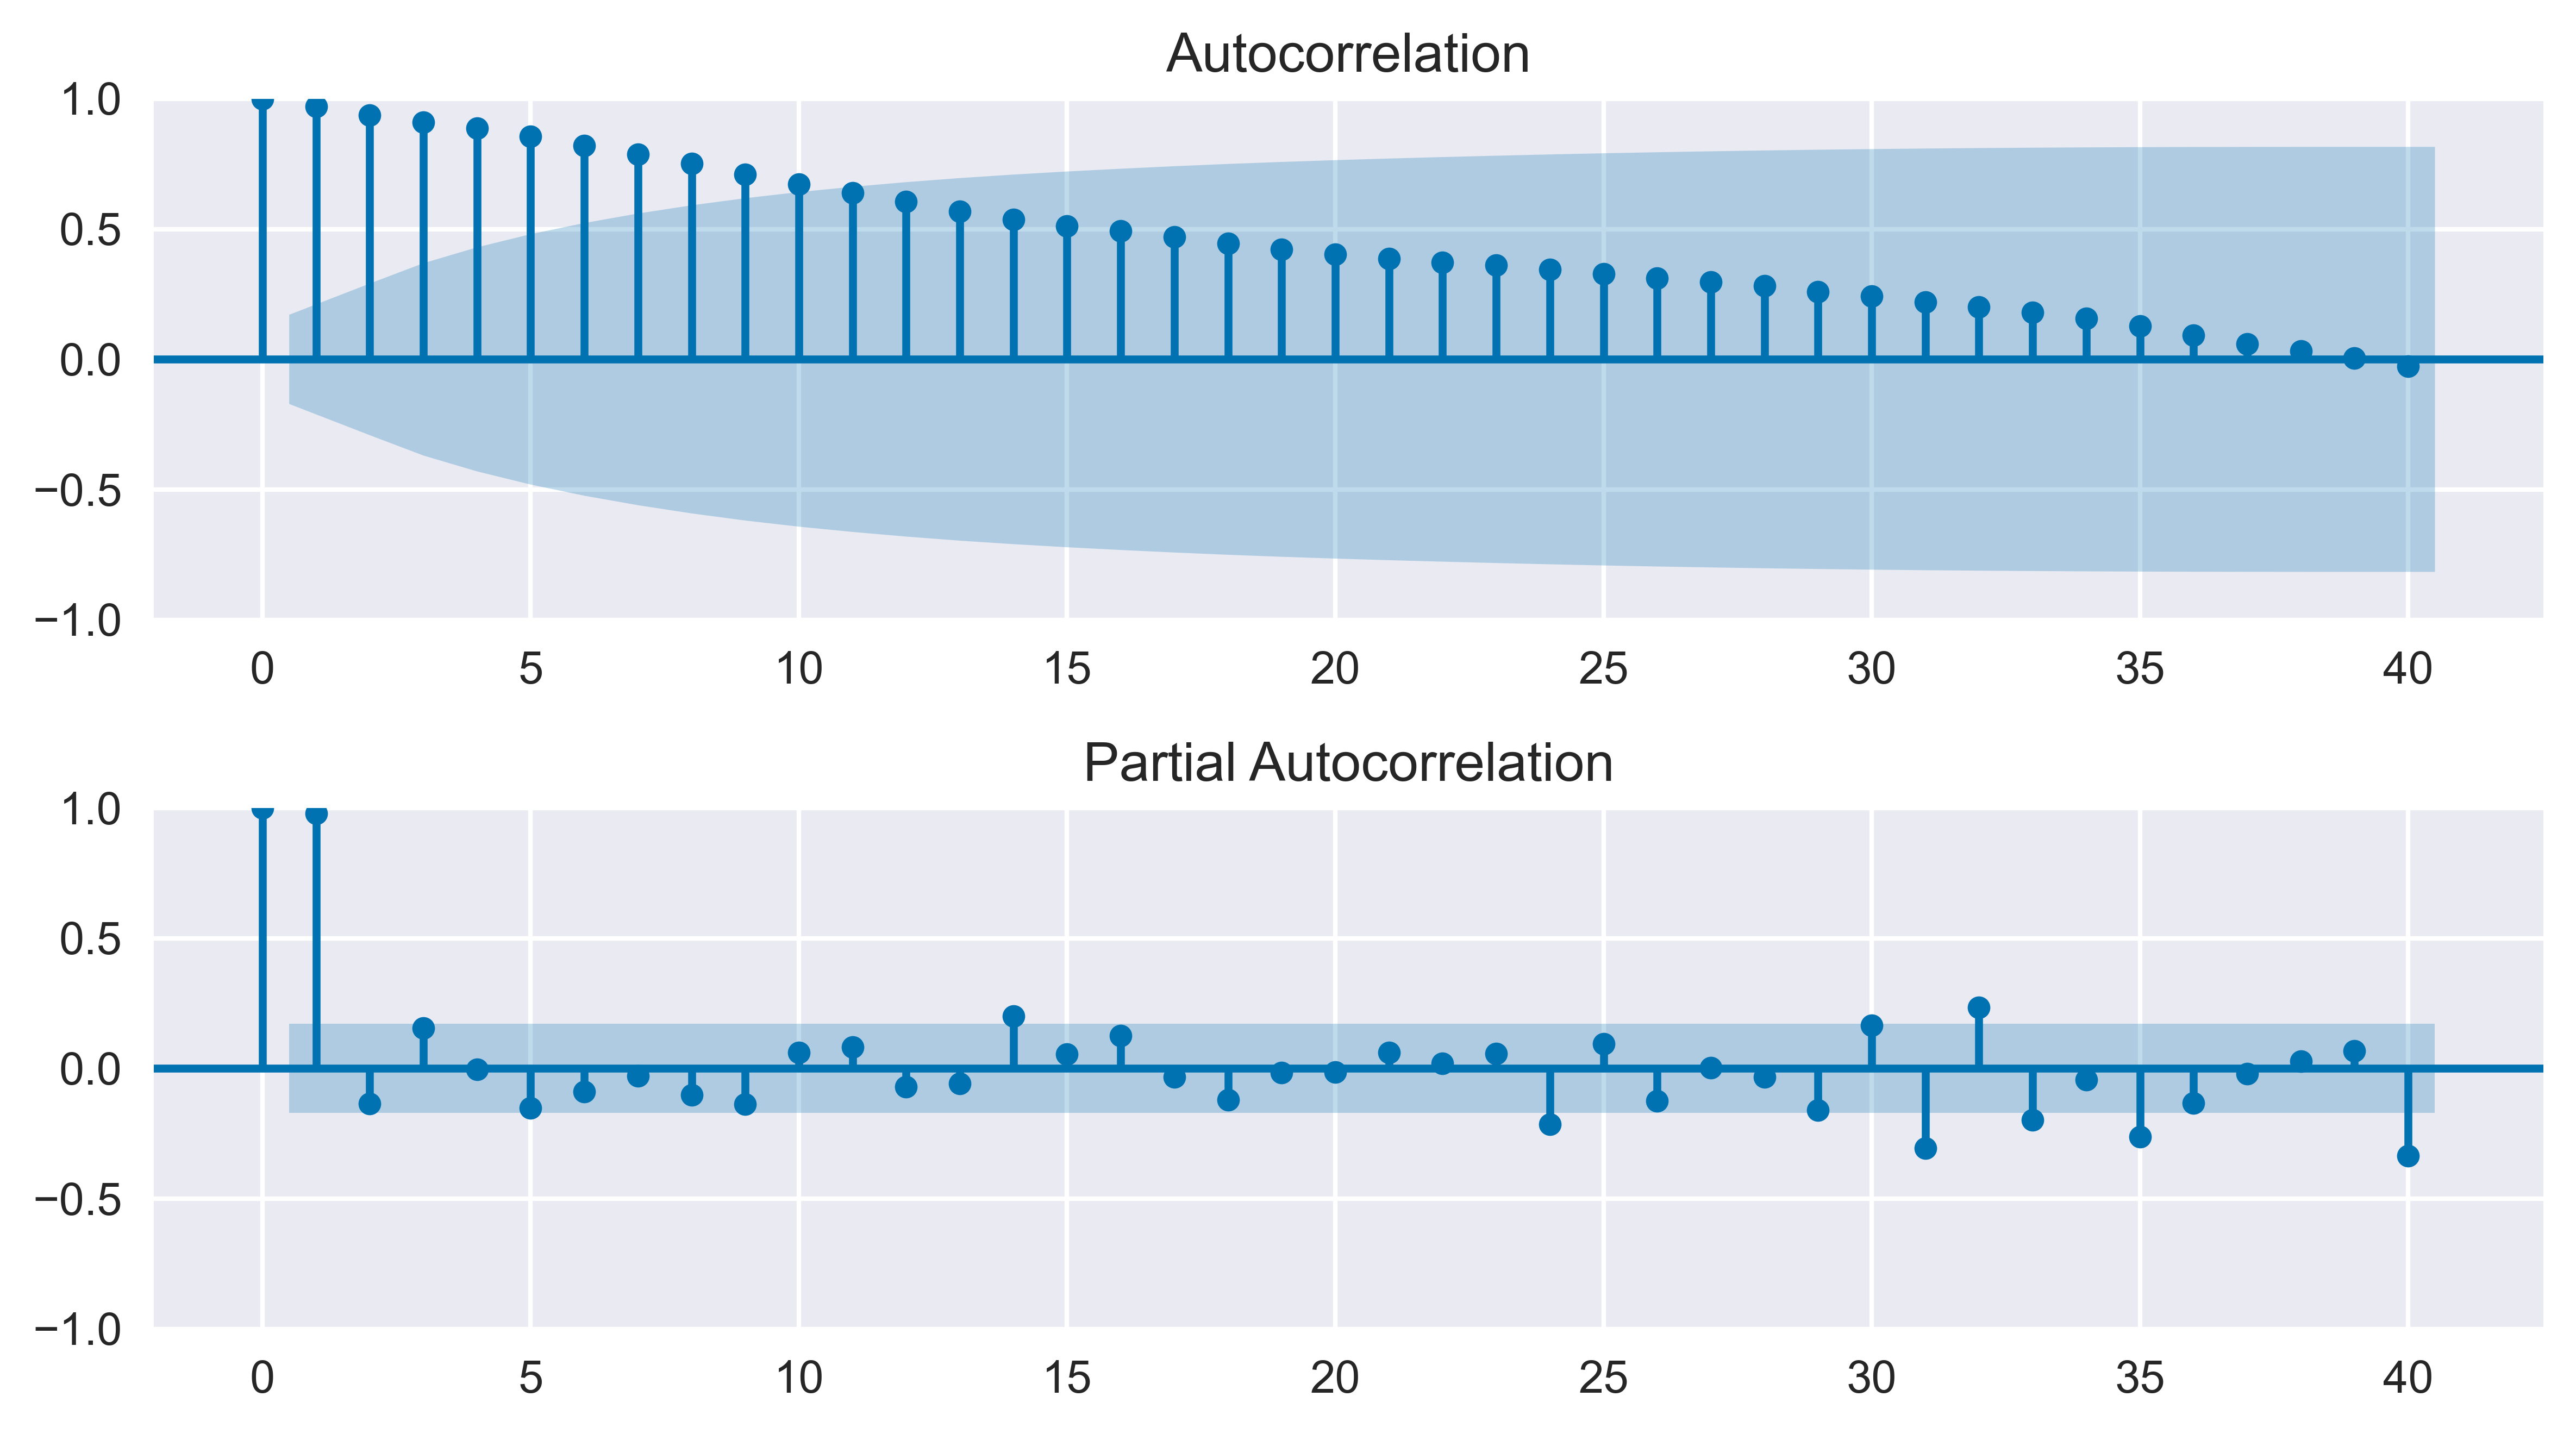

In [68]:
test_autocorrelation(day_df.price_log_diff.dropna())

In [9]:
day_df.head()

,close,price_log,price_log_diff,roll_mean_log_diff,roll_std_log_diff
date,,,,,
2020-01-01,7234.19,8.886574,NaN,NaN,NaN
2020-01-02,7130.98,8.872204,-0.014370,NaN,NaN
2020-01-03,7320.18,8.898390,0.026186,NaN,NaN
2020-01-04,7318.99,8.898228,-0.000163,NaN,NaN
2020-01-05,7468.42,8.918439,0.020211,NaN,NaN


In [13]:
arima = ARIMA(day_df.price_log_diff, order=(2,1,1)).fit()#disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         price_log_diff   No. Observations:                  913
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1630.822
Date:                Sat, 30 Jul 2022   AIC                          -3253.643
Time:                        11:51:12   BIC                          -3234.381
Sample:                    01-01-2020   HQIC                         -3246.289
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0345      0.023     -1.502      0.133      -0.080       0.011
ar.L2          0.0124      0.034      0.368      0.713      -0.053       0.078
ma.L1         -0.9917      0.004   -234.076      0.000      -1.000      -0.983
sigma2         0.0016   4.33e-05     36.861      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               840.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.64
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""